### Задание
- Для отзывов из airlinequality.com собрать отзывы о компании British Airways и сделать анализ на их основе 

### Алгоритм решения
- Собрать отзывы с помощью Beautiful Soup в pd.Dataframe
- Выполнить очистку

С помощью NLTK подготовить каждый отзыв для анализа:
- Определить части речи
- Выполнить лемматизацию

С помощью vaderSentiment выполнить анализ:
- Определить тональность каждого отзыва
- Обозначить тональность категориальным значением

Визуализировать количество отзывов с различной тональностью

# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [ ]:
# !pip install vaderSentiment

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df


,reviews
0,✅ Trip Verified | I am in Australia and on Fr...
1,✅ Trip Verified | At 7.54 am on the day of tr...
2,✅ Trip Verified | Would happily fly them agai...
3,"Not Verified | Flew premium, only worth the e..."
4,✅ Trip Verified | First our morning flight wa...
...,...
995,✅ Trip Verified | London to Montreal. I did m...
996,✅ Trip Verified | Tokyo to Amsterdam via Lond...
997,✅ Trip Verified | Check-in at Vienna Airport w...
998,✅ Trip Verified | Took a day trip to Vienna wi...


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [4]:
df["reviews"] = df['reviews'].str.split('|', expand=True)[1]
df


,reviews
0,"I am in Australia and on Friday night, went ..."
1,At 7.54 am on the day of travel whilst drivi...
2,Would happily fly them again. I had a person...
3,"Flew premium, only worth the extra money for..."
4,First our morning flight was cancelled and m...
...,...
995,London to Montreal. I did my online check-in...
996,Tokyo to Amsterdam via London. On the evenin...
997,Check-in at Vienna Airport was painless. BA u...
998,Took a day trip to Vienna with British Airway...


In [5]:
patt = re.compile('[^A-Za-z]+')
df['cleaned'] = df['reviews'].str.replace(patt, ' ')
df


,reviews,cleaned
0,"I am in Australia and on Friday night, went ...",I am in Australia and on Friday night went on...
1,At 7.54 am on the day of travel whilst drivi...,At am on the day of travel whilst driving to ...
2,Would happily fly them again. I had a person...,Would happily fly them again I had a personal...
3,"Flew premium, only worth the extra money for...",Flew premium only worth the extra money for t...
4,First our morning flight was cancelled and m...,First our morning flight was cancelled and mo...
...,...,...
995,London to Montreal. I did my online check-in...,London to Montreal I did my online check in t...
996,Tokyo to Amsterdam via London. On the evenin...,Tokyo to Amsterdam via London On the evening ...
997,Check-in at Vienna Airport was painless. BA u...,Check in at Vienna Airport was painless BA us...
998,Took a day trip to Vienna with British Airway...,Took a day trip to Vienna with British Airway...


In [6]:
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
stops = set(stopwords.words('english'))

def token_stop_pos(text: str) -> list:
    '''Определение частей речи для каждого слова в отзыве'''
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in stops:
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist 


df['POS tagged'] = df['cleaned'].apply(token_stop_pos)
df


,reviews,cleaned,POS tagged
0,"I am in Australia and on Friday night, went ...",I am in Australia and on Friday night went on...,"[(Australia, n), (Friday, n), (night, n), (wen..."
1,At 7.54 am on the day of travel whilst drivi...,At am on the day of travel whilst driving to ...,"[(day, n), (travel, n), (whilst, n), (driving,..."
2,Would happily fly them again. I had a person...,Would happily fly them again I had a personal...,"[(Would, None), (happily, r), (fly, v), (perso..."
3,"Flew premium, only worth the extra money for...",Flew premium only worth the extra money for t...,"[(Flew, n), (premium, n), (worth, v), (extra, ..."
4,First our morning flight was cancelled and m...,First our morning flight was cancelled and mo...,"[(First, r), (morning, n), (flight, n), (cance..."
...,...,...,...
995,London to Montreal. I did my online check-in...,London to Montreal I did my online check in t...,"[(London, n), (Montreal, n), (online, n), (che..."
996,Tokyo to Amsterdam via London. On the evenin...,Tokyo to Amsterdam via London On the evening ...,"[(Tokyo, n), (Amsterdam, n), (via, None), (Lon..."
997,Check-in at Vienna Airport was painless. BA u...,Check in at Vienna Airport was painless BA us...,"[(Check, n), (Vienna, n), (Airport, n), (painl..."
998,Took a day trip to Vienna with British Airway...,Took a day trip to Vienna with British Airway...,"[(Took, v), (day, n), (trip, n), (Vienna, n), ..."


In [7]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data: list) -> str:
    '''Лематизация частей речи и создание "очищенной" строки с отзывом'''
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


df['Lemma'] = df['POS tagged'].apply(lemmatize)
df

,reviews,cleaned,POS tagged,Lemma
0,"I am in Australia and on Friday night, went ...",I am in Australia and on Friday night went on...,"[(Australia, n), (Friday, n), (night, n), (wen...",Australia Friday night go online book flight...
1,At 7.54 am on the day of travel whilst drivi...,At am on the day of travel whilst driving to ...,"[(day, n), (travel, n), (whilst, n), (driving,...",day travel whilst drive London Heathrow rece...
2,Would happily fly them again. I had a person...,Would happily fly them again I had a personal...,"[(Would, None), (happily, r), (fly, v), (perso...",Would happily fly personal emergency allow r...
3,"Flew premium, only worth the extra money for...",Flew premium only worth the extra money for t...,"[(Flew, n), (premium, n), (worth, v), (extra, ...",Flew premium worth extra money bit extra roo...
4,First our morning flight was cancelled and m...,First our morning flight was cancelled and mo...,"[(First, r), (morning, n), (flight, n), (cance...",First morning flight cancel move afternoon f...
...,...,...,...,...
995,London to Montreal. I did my online check-in...,London to Montreal I did my online check in t...,"[(London, n), (Montreal, n), (online, n), (che...",London Montreal online check night leave go ...
996,Tokyo to Amsterdam via London. On the evenin...,Tokyo to Amsterdam via London On the evening ...,"[(Tokyo, n), (Amsterdam, n), (via, None), (Lon...",Tokyo Amsterdam via London evening departure...
997,Check-in at Vienna Airport was painless. BA u...,Check in at Vienna Airport was painless BA us...,"[(Check, n), (Vienna, n), (Airport, n), (painl...",Check Vienna Airport painless BA use Air Lou...
998,Took a day trip to Vienna with British Airway...,Took a day trip to Vienna with British Airway...,"[(Took, v), (day, n), (trip, n), (Vienna, n), ...",Took day trip Vienna British Airways book la...


In [8]:
analyzer = SentimentIntensityAnalyzer()

def vadersentimentanalysis(review: str) -> float:
    vs = analyzer.polarity_scores(review)
    return vs['compound']


df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

def vader_analysis(compound: float) -> str:
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'


df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df


,reviews,cleaned,POS tagged,Lemma,Sentiment,Analysis
0,"I am in Australia and on Friday night, went ...",I am in Australia and on Friday night went on...,"[(Australia, n), (Friday, n), (night, n), (wen...",Australia Friday night go online book flight...,-0.0258,Negative
1,At 7.54 am on the day of travel whilst drivi...,At am on the day of travel whilst driving to ...,"[(day, n), (travel, n), (whilst, n), (driving,...",day travel whilst drive London Heathrow rece...,-0.6133,Negative
2,Would happily fly them again. I had a person...,Would happily fly them again I had a personal...,"[(Would, None), (happily, r), (fly, v), (perso...",Would happily fly personal emergency allow r...,0.9432,Positive
3,"Flew premium, only worth the extra money for...",Flew premium only worth the extra money for t...,"[(Flew, n), (premium, n), (worth, v), (extra, ...",Flew premium worth extra money bit extra roo...,0.1027,Neutral
4,First our morning flight was cancelled and m...,First our morning flight was cancelled and mo...,"[(First, r), (morning, n), (flight, n), (cance...",First morning flight cancel move afternoon f...,-0.7713,Negative
...,...,...,...,...,...,...
995,London to Montreal. I did my online check-in...,London to Montreal I did my online check in t...,"[(London, n), (Montreal, n), (online, n), (che...",London Montreal online check night leave go ...,-0.3400,Negative
996,Tokyo to Amsterdam via London. On the evenin...,Tokyo to Amsterdam via London On the evening ...,"[(Tokyo, n), (Amsterdam, n), (via, None), (Lon...",Tokyo Amsterdam via London evening departure...,0.4852,Neutral
997,Check-in at Vienna Airport was painless. BA u...,Check in at Vienna Airport was painless BA us...,"[(Check, n), (Vienna, n), (Airport, n), (painl...",Check Vienna Airport painless BA use Air Lou...,0.9699,Positive
998,Took a day trip to Vienna with British Airway...,Took a day trip to Vienna with British Airway...,"[(Took, v), (day, n), (trip, n), (Vienna, n), ...",Took day trip Vienna British Airways book la...,0.6197,Positive


In [9]:
vader_counts = df['Analysis'].value_counts()
vader_counts


Positive    535
Negative    354
Neutral     111
Name: Analysis, dtype: int64

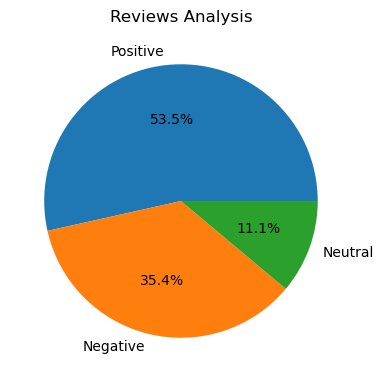

In [10]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0), autopct='%1.1f%%', shadow=False);


In [11]:
df.to_csv("BA_reviews.csv")
